##Chaman Lal  for Deep Learning and NLP Project Pat-2

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 38.0 MB/s 
     |████████████████████████████████| 101 kB 5.7 MB/s 
     |████████████████████████████████| 6.6 MB 30.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
! pip install pyprind


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import InputExample, InputFeatures

config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.5, num_labels=2)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
restaurant = pd.read_csv('/content/drive/MyDrive/project/Restaurant_Reviews.tsv', sep='\t')

In [ ]:
restaurant.shape

(1000, 2)

In [ ]:
restaurant.head()


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
restaurant.isnull().sum()

Review    0
Liked     0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(restaurant, test_size = 0.2, shuffle=True)
train, val = train_test_split(train, test_size = 0.2, shuffle = True)

print('train shape: \n',train.shape,'\ntest shape: \n', test.shape,'\nvalidation shape: \n', val.shape)
#print(train.shape[0]+val.shape[0]+test.shape[0]==df.shape[0])

train shape: 
 (640, 2) 
test shape: 
 (200, 2) 
validation shape: 
 (160, 2)


In [ ]:
def convert_data_to_examples(train, test, val, Review, Liked): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[Review], 
                                                          text_b = None,
                                                          label = x[Liked]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[Review], 
                                                          text_b = None,
                                                          label = x[Liked]), axis = 1)
  

  test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[Review], 
                                                          text_b = None,
                                                          label = x[Liked]), axis = 1)
  

  return train_InputExamples, test_InputExamples, validation_InputExamples

  train_InputExamples, test_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test,
                                                                            val, 
                                                                           'Review', 
                                                                           'Liked')
  

In [ ]:
#from sklearn.model_selection import train_test_split


In [ ]:
#X_train,X_val,y_train,y_val=train_test_split(
 #   restaurant.index.values,
#restaurant.Liked.values,
#test_size=0.15,
#random_state=17,
#stratify=restaurant.Liked.values)

In [ ]:
import tensorflow as tf
import pandas as pd
import os
import shutil
import tensorflow as tf
import tensorflow_datasets



In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


Review = 'Review'
Liked = 'Liked'
train_InputExamples, test_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, val, Review, Liked)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08,
                                                 clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

#checkpoint_filepath = 'best_cobic_att.h5'
#checkpoint = ModelCheckpoint(checkpoint_filepath,monitor='val_loss', 
#                mode='min', verbose=1, save_best_only=True)

history_1 = model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
40/40 [==============================] - 1893s 47s/step - loss: 0.7111 - accuracy: 0.5047 - val_loss: 0.6771 - val_accuracy: 0.5750
Epoch 2/2
40/40 [==============================] - 1847s 46s/step - loss: 0.6696 - accuracy: 0.5844 - val_loss: 0.5609 - val_accuracy: 0.7563


In [ ]:
test_results = model.evaluate(test_data)
print("Test ACCURACY: {:.2f}%".format(test_results[1]*100))

7/7 [==============================] - 94s 13s/step - loss: 0.5750 - accuracy: 0.7450
Test ACCURACY: 74.50%


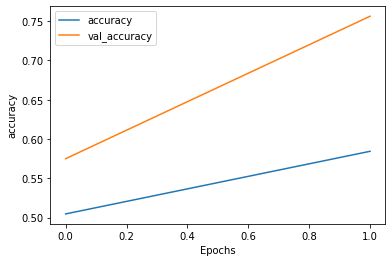

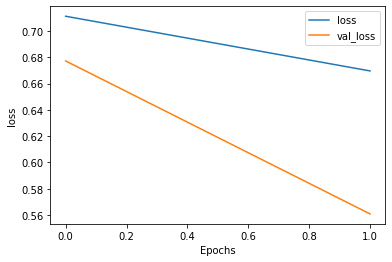

In [ ]:
from matplotlib import pyplot as plt
def plot_graphs(history_1, string):
    plt.plot(history_1.history[string])
    plt.plot(history_1.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

In [ ]:
test_sentence = "Wow... Loved this place	"

predict_input = tokenizer.encode(test_sentence,

truncation=True,

padding=True,

return_tensors="tf")

In [ ]:
tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

Positive
